- http://seaborn.pydata.org/generated/seaborn.pairplot.html
- https://www.kaggle.com/maheshdadhich/strength-of-visualization-python-visuals-tutorial/notebook

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline

In [2]:
filename = "pima-indians-diabetes.data.csv"
col_names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
data = pd.read_csv(filename, names=col_names)

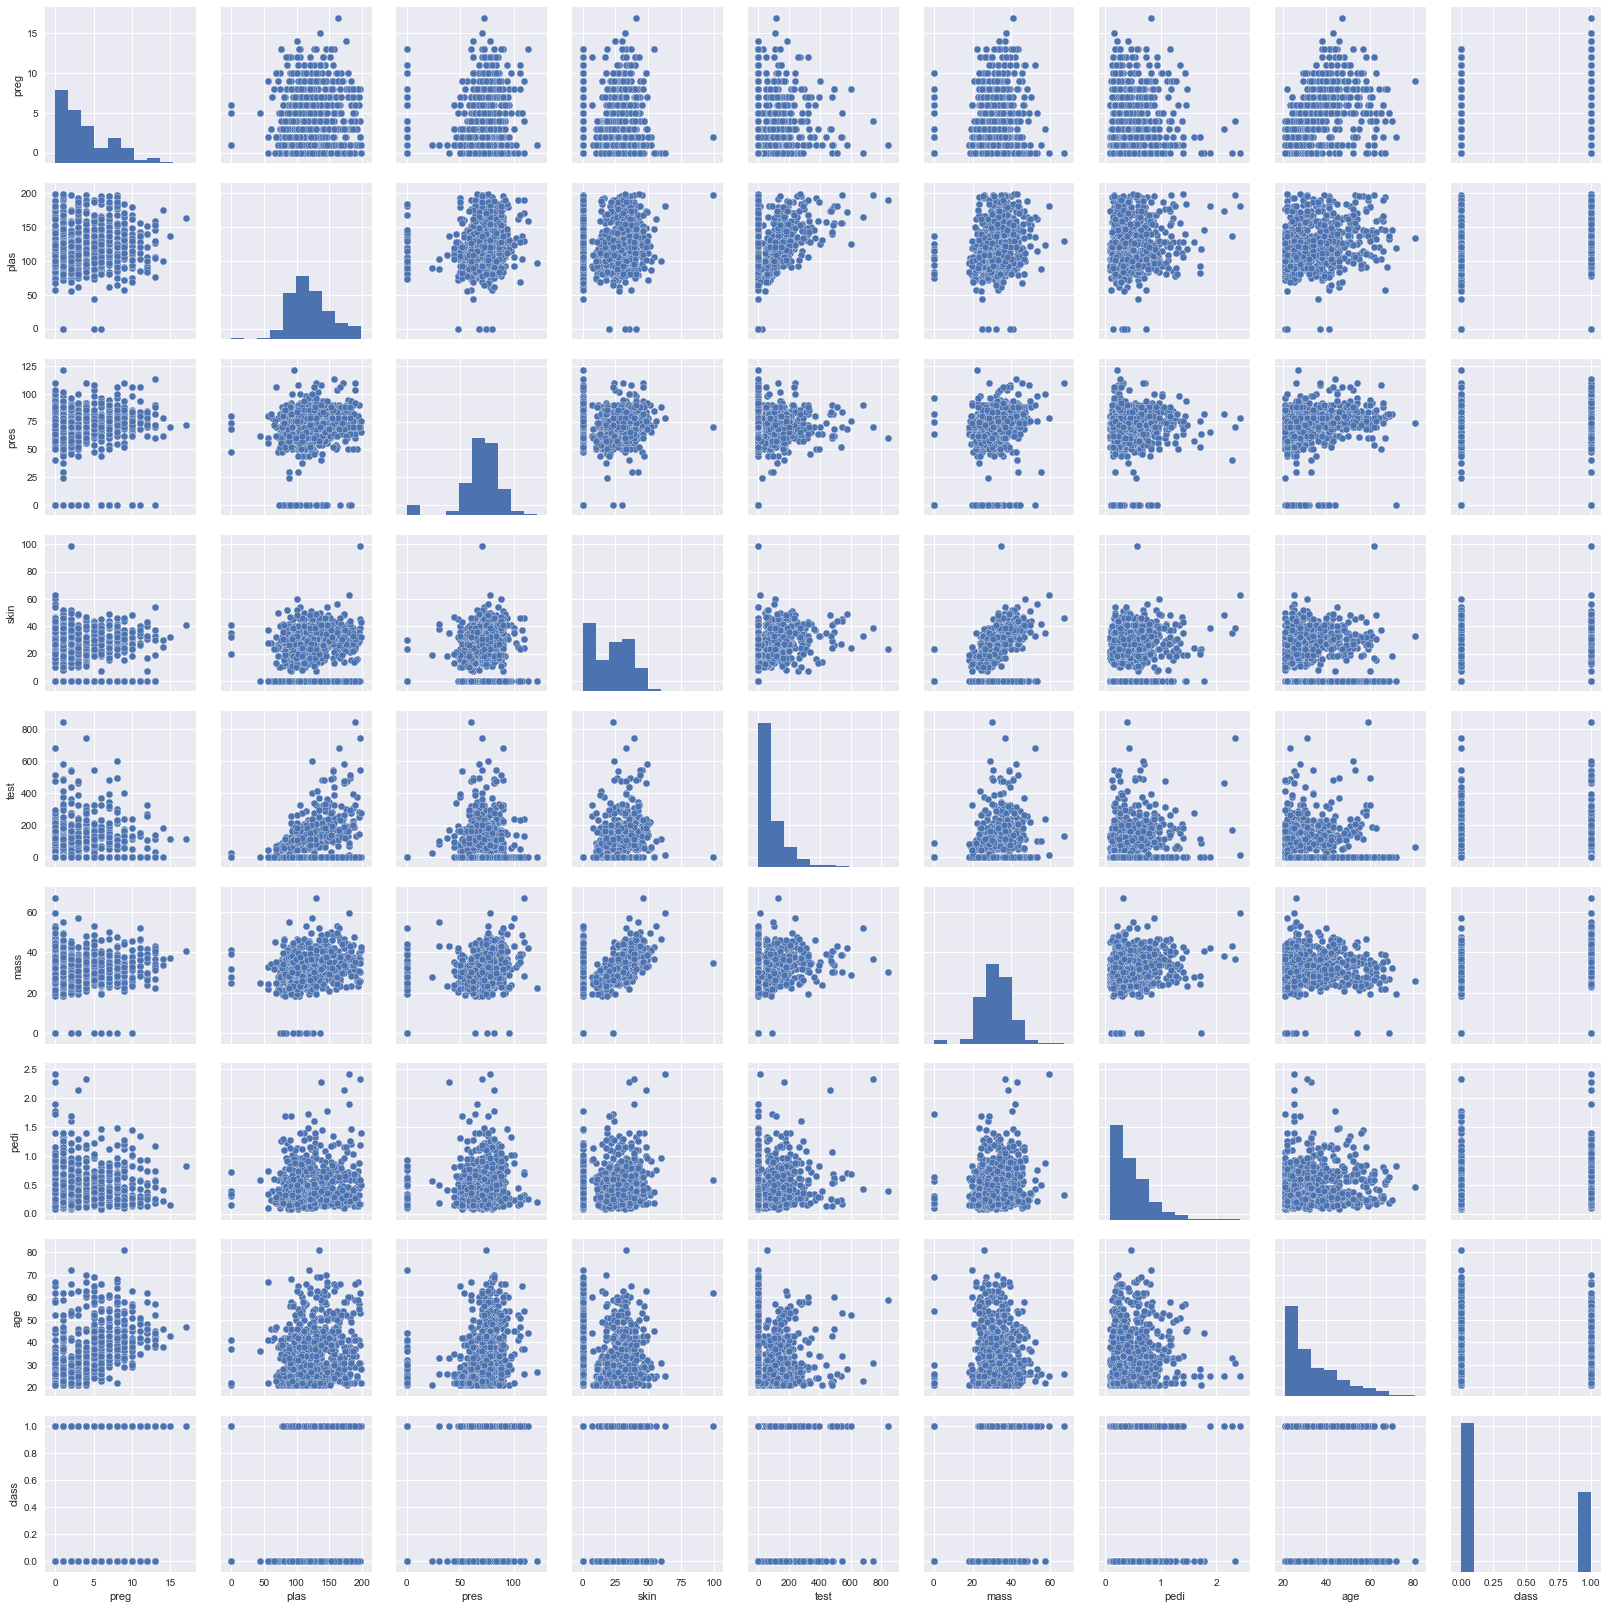

In [15]:
sns.pairplot(data);

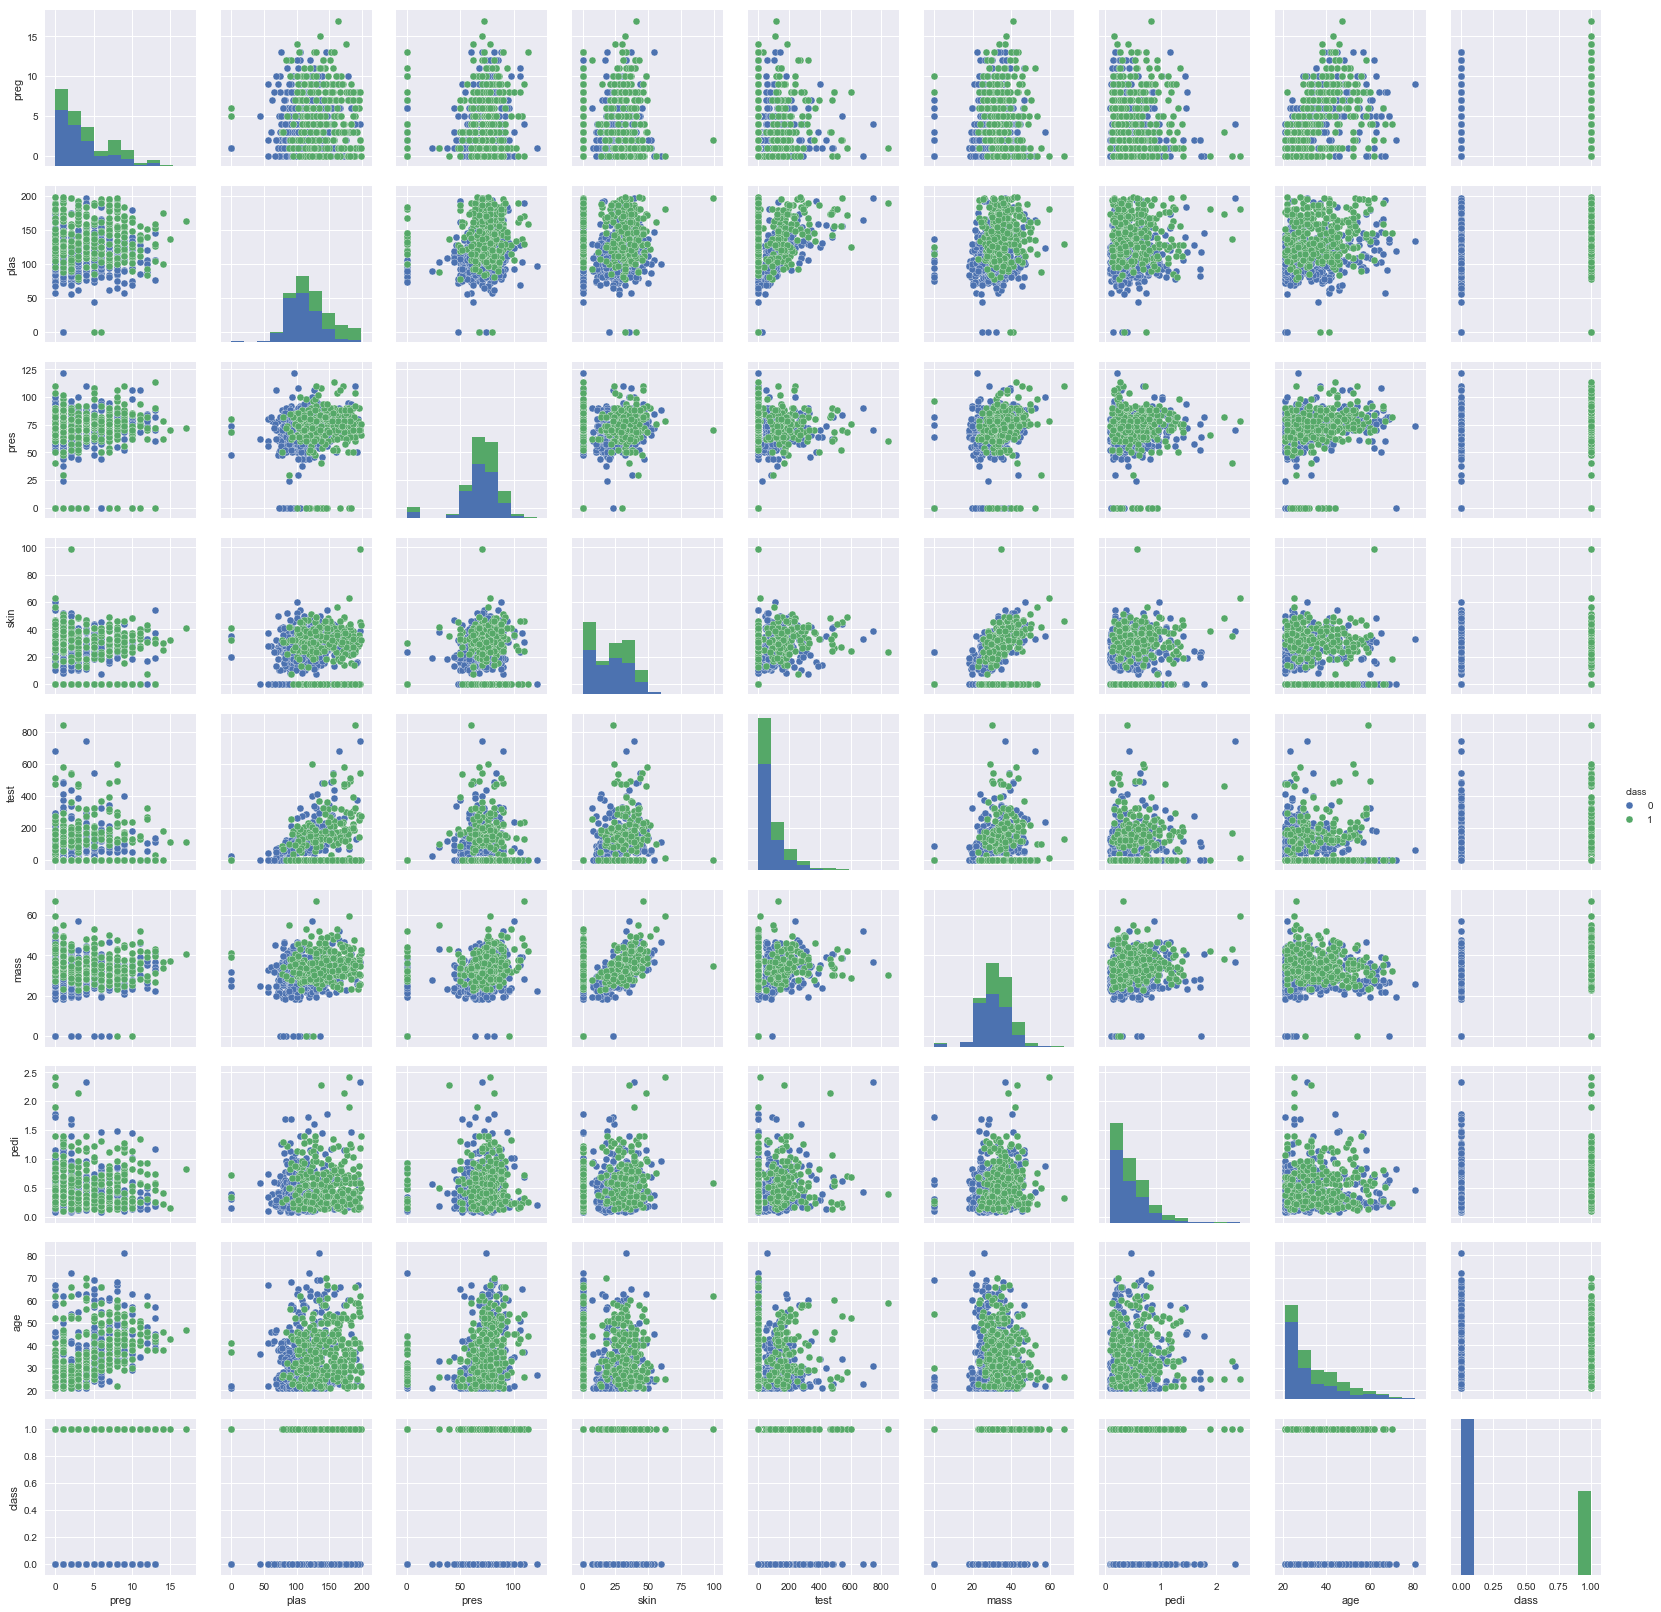

In [4]:
sns.pairplot(data, hue='class');

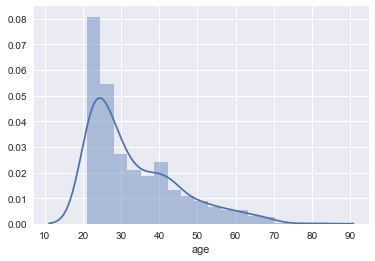

In [5]:
sns.distplot(data['age']);

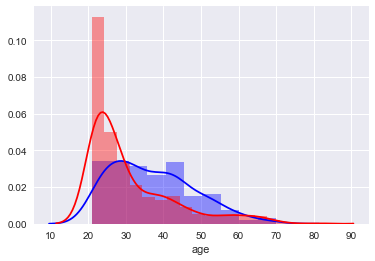

In [6]:
d = data[data['class'] == 1]['age']
c = data[data['class'] == 0]['age']

# Plot a historgram and kernel density estimate
sns.distplot(d, color="b", hist=True, norm_hist=True);
sns.distplot(c, color="r", hist=True, norm_hist=True);

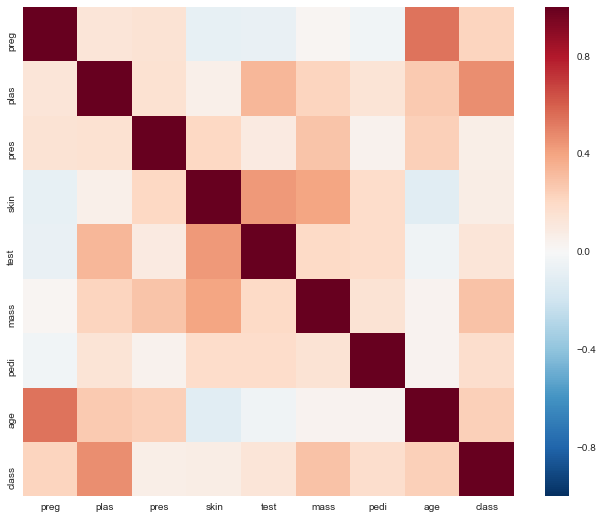

In [14]:
corr = data.corr()

f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(corr);

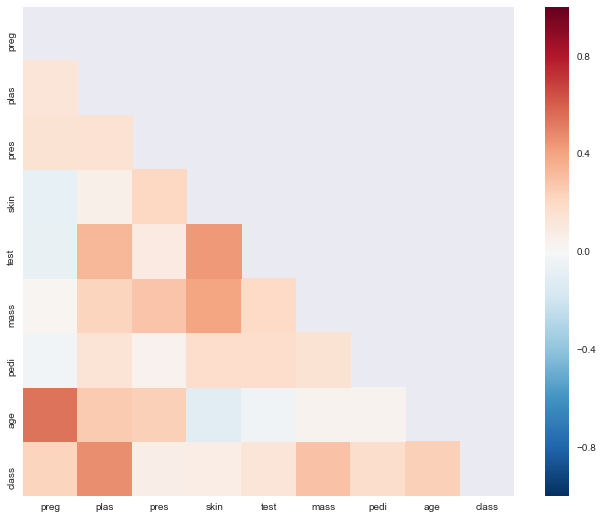

In [13]:
corr = data.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, vmax=1, center=0);

In [9]:
import sklearn
from sklearn.metrics import confusion_matrix

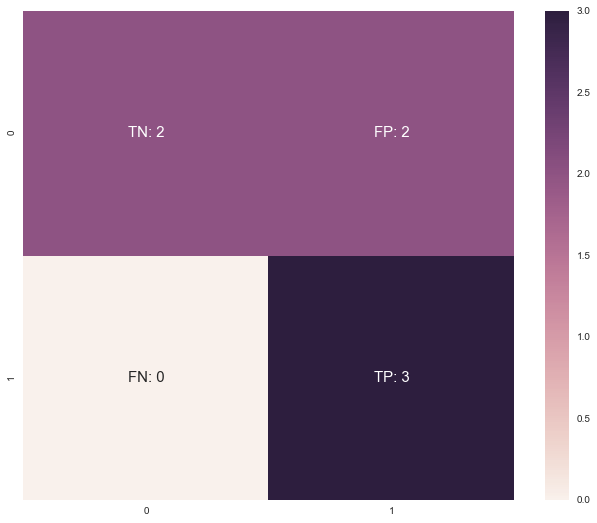

In [10]:
y = np.array([1,0,1,1,0,0,0])
pred = np.array([1,0,1,1,0,1,1])

conf = confusion_matrix(y, pred)
tn, fp, fn, tp = confusion_matrix(y, pred).ravel()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
labels =  np.array([['TN: {}'.format(tn),'FP: {}'.format(fp)],
                    ['FN: {}'.format(fn),'TP: {}'.format(tp)]])
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(conf, annot=labels , fmt= '', annot_kws={"size": 15})

## Fast sklearn for model selection

LR: 0.711400 (0.103834)
LDA: 0.715331 (0.118168)
KNN: 0.647025 (0.106248)
CART: 0.627442 (0.079576)
NB: 0.672013 (0.120358)
RF: 0.716658 (0.105168)


C:\Users\leonardo.petrini\Anaconda3\lib\site-packages\seaborn\categorical.py:2171: UserWarning: The boxplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)


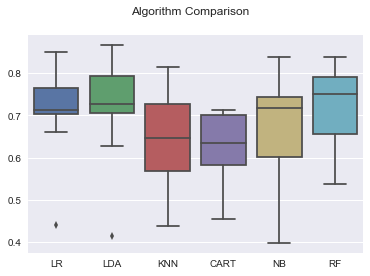

In [11]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

array = data.values
X = data[col_names[:-1]].values
Y = data[col_names[-1]].values

# prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('RF', RandomForestClassifier(n_estimators=150, max_depth=7, criterion='entropy')))

# evaluate each model in turn
results = []
names = []
scoring = 'average_precision'

for name, model in models:
    kfold = KFold(n_splits=10, random_state=2017)
    cv_results = cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
    
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')

results_pd = pd.DataFrame(results).transpose()
results_pd.columns = names
sns.boxplot(results_pd)

## Let's learn functions

In [21]:
from sklearn.calibration import calibration_curve
import pandas as pd
from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.metrics import roc_curve, auc
from matplotlib import pyplot as plt
import seaborn as sns


def auc_plot(y_true, y_pred, size=False):    
    if size:
        fig = plt.figure(1, figsize=(size[0], size[1]))
        
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange',
             lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    
def cal_plot(y_true, y_pred, nbins, y_fixed=False, size=False):
    fraction_of_positives, mean_predicted_value = calibration_curve(y_true, y_pred, False, n_bins=nbins)
    
    if size:
        fig = plt.figure(1, figsize=(size[0], size[1]))   
        
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)         
    ax2 = plt.subplot2grid((3, 1), (2, 0))
    ax1.plot(mean_predicted_value, fraction_of_positives, "s-", label="un-calibrated", linewidth=1, color='blue')
    
    if type(y_fixed) ==  np.ndarray:
        frac, mea = calibration_curve(y_true, y_fixed, False, n_bins=nbins)
        ax1.plot(mea, frac, "s-", label='calibrated', color = 'red', linewidth=2)        

    ax2.hist(y_pred, range=(0, 1), bins=nbins, histtype="step", lw=2)

    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title('Calibration plots  (reliability curve)')
    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")
    ax2.legend(loc="upper center", ncol=2)

    
def ap_plot(y_true, y_pred, size=False):
    if size:
        fig = plt.figure(1, figsize=(size[0], size[1]))
    average_precision = average_precision_score(y_true, y_pred)
    precision, recall, _ = precision_recall_curve(y_true, y_pred)

    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve{}'.format(average_precision))
    
def conf_matrix(y_test, probs, th=.5, size=False):
    """Args
    y_test: np.array of ground truth
    probs: np.array of predictions
    th: float, threshold
    size: tuple, (size_x, size_y)
    """
    preds = [1 if x>th else 0 for x in probs]
    conf = confusion_matrix(y_test, preds)
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

    # Set up the matplotlib figure
    if size:
        f, ax = plt.subplots(figsize=(size[0], size[1]))
        
    labels =  np.array([['TN: {}'.format(tn),'FP: {}'.format(fp)],
                        ['FN: {}'.format(fn),'TP: {}'.format(tp)]])
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(conf, annot=labels , fmt= '', annot_kws={"size": 15})

- You can use %%writefile 'filename'.py to wrap the above cell into a .py
- Check defs_myplots.py and class_myplots.py!

## Hold out split and prediction

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.2, random_state=2017)

clf = RandomForestClassifier(max_depth=7, n_estimators=150, criterion='entropy')
clf.fit(X_train, y_train)        
probs = clf.predict_proba(X_test)[:,1]

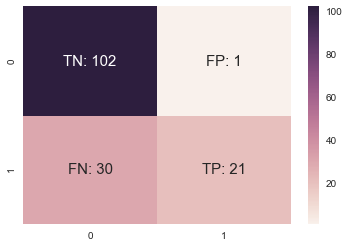

In [17]:
conf_matrix(y_test, probs, th=.7)

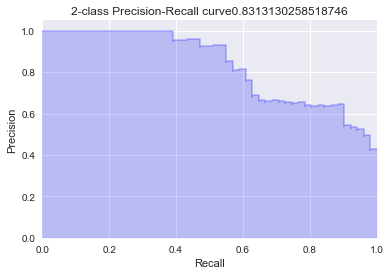

In [18]:
ap_plot(y_test, probs)

C:\Users\leonardo.petrini\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


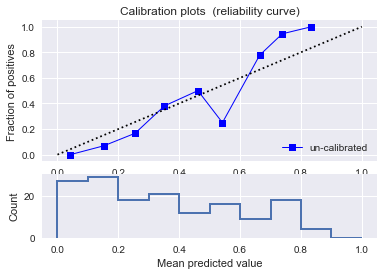

In [19]:
cal_plot(y_test, probs, 10, False)

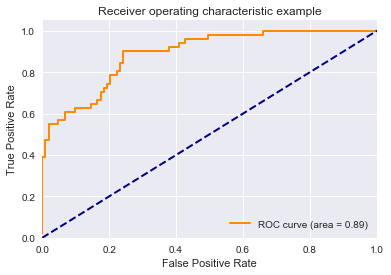

In [22]:
auc_plot(y_test, probs)